In [1]:
import pandas as pd
import json
import folium
import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox
import matplotlib
from shapely.geometry.linestring import LineString

In [2]:
def process_paths(all_paths, G, max_missing=0.3, min_d=1599, max_d=1600):
    valid_paths = []
    risk_paths = []
    # route id
    r_id = 0
    for source in all_paths:
        # get node pair dists and paths
        pair_dists, pair_paths = source[1]
        for k, v in pair_dists.items():
            # only include those above min_d, below max_d
            if (v>=min_d)&(v<max_d):
                p = pair_paths[k]
                r = get_risks([p], G, r_id=r_id)
                # exclude any missing more than max
                if np.mean([x[-1] is None for x in r])<=max_missing:
                    valid_paths.append(p)
                    risk_paths.extend(r)
                    r_id+=1
    return(valid_paths, risk_paths)

def get_risks(paths, G, r_id=None):
    # get risk by path
    risk_paths = []
    for i, p in enumerate(paths):
        if r_id is not None:
            i = r_id
        path_risks = []
        path = zip(p, p[1:])
        for e in path:
            e_d = G.get_edge_data(*e)[0]
            v_risk, b_risk, p_risk = None, None, None
            if str(e_d['osmid']) in osm_preds.index:
                v_risk, b_risk, p_risk = osm_preds.loc[str(e_d['osmid'])]
            risk_paths.append([i, e, e_d['length'], v_risk, b_risk, p_risk])
    return(risk_paths)

def top_routes(risk_df, col, num_routes, high=True):
    if isinstance(num_routes, float):
        num_routes = int(num_routes*risk_df.route_id.nunique())
    if high:
        routes_top = risk_df.groupby('route_id')[col].sum().nlargest(num_routes).index
    else:
        routes_top = risk_df.groupby('route_id')[col].sum().nsmallest(num_routes).index
    valid_top = [valid_paths[idx] for idx in routes_top]
    return(valid_top)

def make_fg(f_map, name='', fg=None, color='red'):
    coords = []
    markers = []
    for l in f_map._children:
        if hasattr(f_map._children[l], 'locations'):
            coords.append(f_map._children[l].locations)
    if fg is None:
        fg = folium.FeatureGroup(name=name)
    folium.PolyLine(coords, color=color).add_to(fg)
    return(fg)

In [3]:
# input the target city
city = 'boston'

In [4]:
# this is a useful colormap for segments
cmap = matplotlib.cm.get_cmap('coolwarm')

In [5]:
# get predictions
segments_pred = gpd.read_file('../data/%s/processed/preds_viz_vehicle.geojson' % city)
b_segments_pred = gpd.read_file('../data/%s/processed/preds_viz_bike.geojson' % city)
p_segments_pred = gpd.read_file('../data/%s/processed/preds_viz_pedestrian.geojson' % city)

In [6]:
# on average, how different are the preds
print(segments_pred.shape)
all_preds = segments_pred.merge(
    p_segments_pred[['segment_id', 'prediction']],
    on='segment_id')
print(all_preds.shape)
all_preds = all_preds.merge(
    b_segments_pred[['segment_id', 'prediction']],
    on='segment_id')
print(all_preds.shape)
all_preds.rename(columns={
    'prediction_x':'v_pred',
    'prediction_y':'p_pred',
    'prediction':'b_pred'},
    inplace=True)
(all_preds.filter(regex='pred').max(axis=1) - all_preds.filter(regex='pred').min(axis=1)).mean()

(22405, 6)
(22405, 7)
(22405, 8)


0.17002662306886268

In [7]:
# get geographies
with open('../data/%s/processed/maps/inters_segments.geojson' % city) as f:
    inters = json.load(f)
with open('../data/%s/processed/maps/non_inters_segments.geojson' % city) as f:
    noninters = json.load(f)
noninters = pd.DataFrame([f['properties'] for f in noninters['features']])

In [8]:
# noninters needs processing into osm ids
osm_noninters = []
for r in noninters.itertuples():
    connected_osm = r.osmid
    if connected_osm.find(',')>-1:
        connected_osm = connected_osm[1:-1].split(', ')
        for c in connected_osm:
            osm_noninters.append((r.id, c))
    else:
        osm_noninters.append((r.id, connected_osm))

In [9]:
# need to get the osmid for all connected segments for intersections
# for non-intersections, just take the osmid
# i'd like to make this a df so I can do some manipulations easy
osm_inters = []
for inter in inters['features']:
    for seg in inter['properties']['connected_segments']:
        connected_osm = noninters[noninters.id==seg]['osmid'].values[0]
        if connected_osm.find(',')>-1:
            connected_osm = connected_osm[1:-1].split(', ')
            for c in connected_osm:
                osm_inters.append((inter['properties']['id'], c))
        else:
            osm_inters.append((inter['properties']['id'], connected_osm))
            
osm_inters.extend(osm_noninters)
osm_seg = pd.DataFrame(osm_inters, columns=['id', 'osmid'])
osm_seg = osm_seg.astype(str)

In [10]:
# get risk per modes
pred_cols = ['v_pred', 'b_pred', 'p_pred']
pred_osm_seg = osm_seg.merge(
    all_preds[['segment_id']+pred_cols], 
    left_on='id', right_on='segment_id')

In [11]:
# using the mean prediction of any segments that are part of an osm segment
osm_preds = pred_osm_seg.groupby('osmid')[pred_cols].mean()

/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs


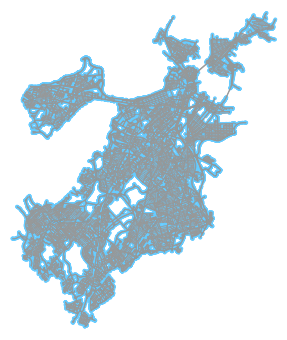

(<Figure size 489.712x432 with 1 Axes>, <AxesSubplot:>)

In [12]:
# full city map
G = ox.graph_from_place('%s, Massachusetts, USA' % city, 
                        network_type='drive', 
                        simplify=False)
ox.plot_graph(G)

In [13]:
# can input origin/destination to get all routes between points
# can also just put in orgin, get all routes within cutoff
# also can just put in an address if you already pull in the city map
#q = 'Beacon Street and Massachusetts Avenue, Boston, Massachusetts, USA'
#nearest_node = ox.get_nearest_node(G, ox.geocode(q))
#p = G.nodes.get(nearest_node)['y'], G.nodes.get(nearest_node)['x']
# just hard-coding a location here
o = (42.350830, -71.089473)
nearest_o = ox.get_nearest_node(G, o)
#nearest_d = ox.get_nearest_node(G, d)
p = G.nodes.get(nearest_o)['y'], G.nodes.get(nearest_o)['x']

In [14]:
# get graph from point
sub_G = ox.graph_from_point(p, network_type='drive',# dist_type='network',
                        simplify=False, distance=1600)

In [15]:
# this needs to be done to remove cambridge
city = 'Boston'
place = ox.gdf_from_place(city)
coords_city = place.geometry.total_bounds
sub_G = ox.core.truncate_graph_polygon(sub_G, place.geometry.iloc[0])

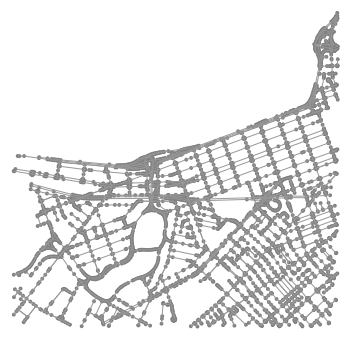

(<Figure size 604.06x432 with 1 Axes>, <AxesSubplot:>)

In [16]:
ox.plot_graph(sub_G, bgcolor='w', node_color='gray')

In [79]:
# get all paths that are less than a mile (~1600 meters)
all_paths = [x for x in nx.all_pairs_dijkstra(sub_G, cutoff=1600, weight='length')]

In [81]:
valid_paths, risk_paths = process_paths(all_paths, sub_G)

In [85]:
# construct df for risk paths (easier to manipulate)
r_df = pd.DataFrame(risk_paths)
r_df.columns = ['route_id', 'edge', 'length']+pred_cols
# calculate risk per m
risk_per_m = r_df[pred_cols].apply(lambda x: x/r_df['length'])
risk_per_m['route_id'] = r_df['route_id']


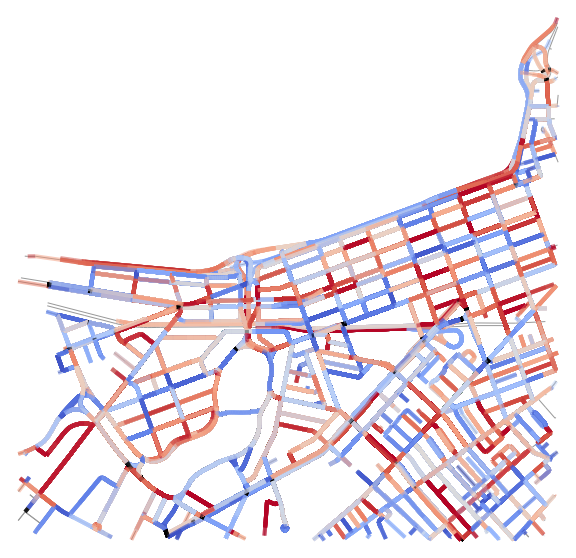

(<Figure size 1006.77x720 with 1 Axes>, <AxesSubplot:>)

In [47]:
# risk to which mode
risk_col = 'b_pred'

# a few ways to calculate risk
# rolling average over the route
#cumavg = r.groupby('route_id')[pred_cols].rolling(window=2).mean()
# calculate risk per m
risk_per_m = r_df[pred_cols].apply(lambda x: x/r_df['length'])
risk_per_m['route_id'] = r_df['route_id']
# ranking of the elements of the route
rank = r_df.groupby('route_id')[pred_cols].rank()
# need to normalize this to the maximum rank (for longer routes)
v = rank.groupby(r_df['route_id'])[risk_col].apply(lambda g: g.values/g.max())
rc = [cmap(x) for p in v for x in p]
nc = 'b'
ox.plot_graph_routes(sub_G, valid_paths, route_color=rc, bgcolor='w', orig_dest_node_alpha=0,
                     node_color='gray', node_alpha=0, fig_height=10)

In [234]:
# collect top risky routes
top = 10
top_collect = {}
pred_cols = ['v_pred', 'b_pred', 'p_pred']
for col in pred_cols:
    top_collect[col] = top_routes(risk_per_m, col, top)

In [236]:
# hack: only way I could figure to make routes into layers
lat, lng = o
city_map = folium.Map([lat, lng], tiles='Cartodb Positron', zoom_start=15)
clrs = ['blue', 'yellow', 'red']
labels = ['vehicle', 'bike', 'pedestrian']
for i, col in enumerate(pred_cols):
    col_map = folium.Map([lat, lng])
    coords = []
    for r in top_collect[col]:
        ox.plot_route_folium(sub_G, r, route_map=col_map)
    for l in col_map._children:
        if hasattr(col_map._children[l], 'locations'):
            coords.append(col_map._children[l].locations)
    f = folium.FeatureGroup(name=labels[i])
    folium.PolyLine(coords, color=clrs[i]).add_to(f)
    f.add_to(city_map)
folium.LayerControl(position='bottomright').add_to(city_map)
city_map

In [237]:
city_map.save('boston_high_routes.html')

#### Routes to specific destination
This section shows how to use the routing technique above for all paths to a specific destination

/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs


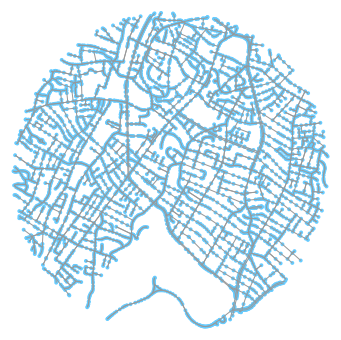

(<Figure size 585.24x432 with 1 Axes>, <AxesSubplot:>)

In [238]:
# specify a place to get place-specific graph
place = 'David A Ellis School, Boston, Massachusetts, USA'
G = ox.graph_from_place(place, network_type='drive', 
                        simplify=False, buffer_dist=1602)
ox.plot_graph(G)

In [362]:
# get the nearest node
lat, lng = ox.geocode(place)
nearest = ox.get_nearest_node(G, (lat, lng))
# all paths to target
all_paths = nx.shortest_path(G, target=nearest, weight='length')
# separately get lengths
all_lengths = nx.shortest_path_length(G, target=nearest, weight='length')

In [370]:
valid_paths = []
for k in all_lengths:
    # only need paths that are within a certain range
    min_d = 800
    max_d = 1600
    d = all_lengths[k]
    if (d>=min_d)&(d<=max_d):
        valid_paths.append(all_paths[k])

In [374]:
# having some issues with overlapping routes here
keep_path_idxs = set()
for i, v in enumerate(valid_paths):
    overlap = [i]
    for ii, vv in enumerate(valid_paths):
        if v!=vv:
            if len(set(v).intersection(set(vv)))>=0.9*len(v):
                overlap.append(ii)
    keep_path_idxs.add(sorted(overlap)[0])

In [375]:
keep_paths = [valid_paths[i] for i in keep_path_idxs]

In [376]:
risk_paths = get_risks(keep_paths, G)

In [377]:
# construct df for risk paths (easier to manipulate)
r_df = pd.DataFrame(risk_paths)
r_df.columns = ['route_id', 'edge', 'length']+pred_cols
# calculate risk per m
risk_per_m = r_df[pred_cols].apply(lambda x: x/r_df['length'])
risk_per_m['route_id'] = r_df['route_id']

In [386]:
# visualize high/low risk
# this is all a bit hacky to get the layout I wanted
top = 5
col = 'p_pred'
top_high = top_routes(risk_per_m, col, top, high=True)
top_low = top_routes(risk_per_m, col, top, high=False)
city_map = folium.Map([lat, lng], tiles='Cartodb Positron', zoom_start=15)
folium.Marker([lat, lng], icon=folium.Icon(color='gray'),tooltip=place).add_to(city_map)
top_map_low = folium.Map([lat, lng], tiles='Cartodb Positron', zoom_start=12)
fg_low = folium.FeatureGroup(name='low risk')
for route in top_low:
    folium.Marker([G.nodes[route[0]]['y'], 
                   G.nodes[route[0]]['x']],
                  icon=folium.Icon(color='blue'),
                  tooltip='Low risk route start').add_to(fg_low)
    ox.plot_route_folium(G, route, route_map=top_map_low, route_color='blue')
fg_low = make_fg(top_map_low, fg=fg_low, color='blue')
fg_low.add_to(city_map)
top_map_high = folium.Map([lat, lng], tiles='Cartodb Positron', zoom_start=12)
fg_high = folium.FeatureGroup(name='high risk')
for route in top_high:
    folium.Marker([G.nodes[route[0]]['y'], 
                   G.nodes[route[0]]['x']],
                  icon=folium.Icon(color='red'),
                  tooltip='High risk route start').add_to(fg_high)
    ox.plot_route_folium(G, route, route_map=top_map_high, route_color='red')
fg_high = make_fg(top_map_high, fg=fg_high, color='red')
fg_high.add_to(city_map)
folium.LayerControl(position='bottomright').add_to(city_map)
city_map

In [383]:
city_map.save('school_routes.html')